In [1]:
!pip install transformers


You should consider upgrading via the '/usr/local/opt/python/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import (
    AdamW,
    BertConfig,
    BertTokenizer,
    BertForSequenceClassification,
    XLNetConfig, 
    XLNetForSequenceClassification, 
    XLNetTokenizer,
    XLMConfig, 
    XLMForSequenceClassification, 
    XLMTokenizer,
    RobertaConfig, 
    RobertaForSequenceClassification, 
    RobertaTokenizer,
    DistilBertConfig, 
    DistilBertForSequenceClassification, 
    DistilBertTokenizer,
    AlbertConfig, 
    AlbertForSequenceClassification, 
    AlbertTokenizer,
    XLMRobertaConfig, 
    XLMRobertaForSequenceClassification, 
    XLMRobertaTokenizer,
    get_linear_schedule_with_warmup
)
import math


In [3]:
MODEL_CLASSES = {
    "bert": (BertConfig, BertForSequenceClassification, BertTokenizer),
    "xlnet": (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer),
    "xlm": (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    "roberta": (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer),
    "distilbert": (DistilBertConfig, DistilBertForSequenceClassification, DistilBertTokenizer),
    "albert": (AlbertConfig, AlbertForSequenceClassification, AlbertTokenizer),
    "xlmroberta": (XLMRobertaConfig, XLMRobertaForSequenceClassification, XLMRobertaTokenizer),
} 

In [4]:
## Model setup
model_type = 'bert'
model_name = 'bert-base-cased'
config_class, model_class, tokenizer_class = MODEL_CLASSES[model_type]

tokenizer = tokenizer_class.from_pretrained(model_name, do_lower_case=False)

In [5]:
# PARAMETERS
MAX_LEN = 128


In [6]:
ROOT = ""
DATA_PATH = ROOT + 'datasets/'
def get_data(subset='train'):
    texts = []
    for root, folders, files in os.walk(DATA_PATH + '/C50/C50{}'.format(subset)):
        if len(files) == 0:
            continue

        author = root.split('/')[-1]
        for file in files:
            if file.endswith('.txt'):
                with open(os.path.join(root, file), 'r') as f:
                    texts.append({
                        'author': author,
                        'text': f.read(),

                    })
    df = pd.DataFrame(texts)
    unique_authors = sorted(df['author'].unique())
    num_authors = len(unique_authors)
    author_to_id = { unique_authors[i]: i for i in range(num_authors) }
    df = df.assign(author_id=df['author'].apply(lambda a: author_to_id[a]))
    return df

In [7]:
def get_encodings(texts):
    token_ids = []
    attention_masks = []
    for text in texts:
        token_id = tokenizer.encode(text, 
                                    add_special_tokens=True, 
                                    max_length=MAX_LEN,
                                    pad_to_max_length=True)
        token_ids.append(token_id)
    return token_ids



def get_attention_masks(padded_encodings):
    attention_masks = []
    for encoding in padded_encodings:
        attention_mask = [int(token_id > 0) for token_id in encoding]
        attention_masks.append(attention_mask)
    print(attention_masks)
    return attention_masks

In [ ]:
train_df = pd.read_pickle(DATA_PATH + 'reuters50_train.pkl')
test_df = pd.read_pickle(DATA_PATH + 'reuters50_test.pkl')

In [ ]:
train_encodings = get_encodings(train_df.text.values)
train_attention_masks = get_attention_masks(train_encodings)

test_encodings = get_encodings(test_df.text.values)
test_attention_masks = get_attention_masks(test_encodings)


[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
train_input_ids = torch.tensor(train_encodings)
train_masks = torch.tensor(train_attention_masks)
train_labels = torch.tensor(train_df.author_id.values)


test_input_ids = torch.tensor(test_encodings)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_df.author_id.values)

In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def get_confusion_matrix(preds, labels):
    """
    Rows = true labels
    Columns = classified labels
    """
    confusion_matrix = np.zeros((50, 50))
    preds = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    for i, label in enumerate(labels):
        pred = preds[i]
        confusion_matrix[label][pred] += 1

    return confusion_matrix

def parse_confusion_matrix(confusion_matrix):
    """
    Rows = labels
    Col0 = tp
    Col1 = fp
    Col2 = fn
    Col3 = tn
    """
    parsed_confusion_matrix = np.zeros((50, 4))
    for i in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[i][i]
        fp = confusion_matrix[:, i].sum() - tp
        fn = confusion_matrix[i, :].sum() - tp 
        tn = confusion_matrix.sum() - tp - fp - fn

    parsed_confusion_matrix[i][0] = tp
    parsed_confusion_matrix[i][1] = fp
    parsed_confusion_matrix[i][2] = fn
    parsed_confusion_matrix[i][3] = tn
    return parsed_confusion_matrix

def calculate_avg_precision(parsed_confusion_matrix):
    """
    Calculates macro average precision
    """
    total_precision = 0
    num_classes = parsed_confusion_matrix.shape[0]
    for i in range(num_classes):
        tp, fp, _, _ = parsed_confusion_matrix[i]
        precision = tp / (tp + fp)
        if not np.isnan(precision):
            total_precision += precision
    return total_precision / num_classes

def calculate_avg_recall(parsed_confusion_matrix):
    """
    Calculates macro average recall
    """
    total_recall = 0
    num_classes = parsed_confusion_matrix.shape[0]
    for i in range(num_classes):
        tp, _, fn, _ = parsed_confusion_matrix[i]
        recall = tp / (tp + fn)
        if not np.isnan(recall):
            total_recall += recall
    return total_recall / num_classes

def calculate_avg_f1(parsed_confusion_matrix):
    """
    Calculates macro average f1 score
    """
    total_f1 = 0
    num_classes = parsed_confusion_matrix.shape[0]
    for i in range(num_classes):
        tp, fp, fn, _ = parsed_confusion_matrix[i]
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2*((precision * recall) / (precision + recall))
        if not np.isnan(f1):
            total_f1 += f1
    return total_f1 / num_classes

def calculate_avg_mcc(parsed_confusion_matrix):
    """
    Calculates macro average Matthews correlation coefficient
    """
    total_mcc = 0
    num_classes = parsed_confusion_matrix.shape[0]
    for i in range(num_classes):
        tp, fp, fn, tn = parsed_confusion_matrix[i]
        mcc = (tp * tn - fp * fn) / math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        if not np.isnan(mcc):
            total_mcc += mcc
    return total_mcc / num_classes

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import string
import nltk
nltk.download('popular')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [ ]:
#Call on each x of the array 
def punctuation_removal(x):
    temp = ""
    for i in x:
        if i not in string.punctuation:
            temp+=i
    return temp

#Call on each x of the array 
def lemmatize(x):
    temp = ""
    for i in range(len(x.split())):
        lem = lemmatizer.lemmatize(x.split()[i], pos="v")
        temp += lem + " "
    temp = temp.rstrip()
    return temp

#Call on each x of the array
def stopword_removal(x):
    temp = ""
    for i in x.split():
        if i.lower() not in stopwords.words('english'):
            temp += i + " "
    temp = temp.rstrip()
    return temp

def text_processing(X_train):
    processed_text = []
    for i in X_train:
        temp = punctuation_removal(i)
        temp = lemmatize(temp)
        temp = stopword_removal(temp)
        processed_text.append(temp)
    return processed_text

# from sklearn.feature_extraction.text import CountVectorizer
# bow_transformer = CountVectorizer(analyzer=text_processing).fit(train_df.text.values)
# text_bow_train = bow_transformer.transform(train_df.text.values)
# text_bow_test = bow_transformer.transform(test_df.text.values)

In [ ]:
# train_bow = torch.tensor(text_bow_train.todense(), dtype = torch.double, device = device)
# test_bow = torch.tensor(text_bow_test.todense(), dtype = torch.double, device = device)

In [ ]:
# Load pre-made BOWs
import pickle
train_xbow_p = DATA_PATH + "text_bow_train.p"
test_xbow_p = DATA_PATH + "text_bow_test.p"
train_bow = pickle.load(open(train_xbow_p, "rb"))
test_bow = pickle.load(open(test_xbow_p, "rb"))

In [ ]:
train_bow = torch.tensor(train_bow.todense(), dtype = torch.double, device = device)
test_bow = torch.tensor(test_bow.todense(), dtype = torch.double, device = device)

In [ ]:
# Parameters
batch_size = 8
lr = 1e-4
eps = 1e-8
epochs = 20

In [ ]:
train_dataset = TensorDataset(train_input_ids, train_masks, train_bow, train_labels)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

test_dataset = TensorDataset(test_input_ids, test_masks, test_bow, test_labels)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

class NeuralNet(nn.Module):
    """
    End to end neural net that combines with BERT model
    """
    def __init__(self, bert_model):
        super().__init__()
        self.hidden1 = nn.Linear(815, 700)
        self.output = nn.Linear(700, 50)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(700)
        self.bert = bert_model

    
    def forward(self, x):
        x = self.hidden1(x)
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.relu(x)

        x = self.output(x)
        return x



In [ ]:
## Instantiate a brand new bert model

config = config_class.from_pretrained(model_name, num_labels=50, output_hidden_states=True)
bert = model_class.from_pretrained(model_name, config=config)

bert.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
def train(model, optimizer, scheduler, loss_function, epochs):

    # ========================================
    #               Training
    # ========================================

    train_loss_values = []
    test_loss_values = []

    for epoch in range(1, epochs+1):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch, epochs))
        print('Training...')

        nnet.train()
        t0 = time.time()

        train_loss = 0
        train_acc = 0

        for step, batch in enumerate(train_dataloader):

            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            input_ids, input_masks, bow, labels = tuple(t.to(device) for t in batch)

            # Run input IDs and masks through BERT first to get embeddings
            # then combine with BOW to run through rest of nnet model

            optimizer.zero_grad()
            output = nnet.bert(input_ids, attention_mask=input_masks)
            embeddings = output[1][0]
            embeddings = embeddings.mean(dim=1).double() 
      
            features_comb = torch.cat((embeddings, bow), dim=1)

            outputs = nnet(features_comb)
            vals, inds = torch.max(outputs, dim=1)
            
            loss = loss_function(outputs, labels)
            train_loss += loss

            acc = torch.eq(inds, labels).sum().item() / labels.shape[0]
            train_acc += acc

            # torch.nn.utils.clip_grad_norm_(nnet.parameters(), 1.0)

            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()

        elapsed = format_time(time.time() - t0)
        avg_train_loss = train_loss / len(train_dataloader)
        avg_train_acc = train_acc / len(train_dataloader)
        train_loss_values.append(avg_train_loss)
        print(f"Epoch: [{epoch}/{epochs}], elapsed: {elapsed}, loss: {avg_train_loss}, acc: {avg_train_acc}")

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        nnet.eval()
        t0 = time.time()
        
        test_loss = 0
        test_acc = 0
        confusion_matrix = torch.zeros((50, 50))

        for batch in test_dataloader:

            input_ids, input_masks, bow, labels = tuple(t.to(device) for t in batch)

            with torch.no_grad():
                embeddings = nnet.bert(input_ids, attention_mask=input_masks)[1][0]
                embeddings = embeddings.mean(dim=1).double() 

                features_comb = torch.cat((embeddings, bow), dim=1)

                outputs = nnet(features_comb)
                vals, inds = torch.max(outputs, dim=1)
            
                loss = loss_function(outputs, labels)
                test_loss += loss

                acc = torch.eq(inds, labels).sum().item() / labels.shape[0]
                test_acc += acc

                preds = outputs.detach().cpu().numpy()
                labels = labels.detach().cpu().numpy()

                tmp_confusion_matrix = get_confusion_matrix(preds, labels)
                confusion_matrix += tmp_confusion_matrix

        elapsed = format_time(time.time() - t0)
        avg_test_loss = test_loss / len(test_dataloader)
        avg_test_acc = test_acc / len(test_dataloader)
        test_loss_values.append(avg_test_loss)

        parsed_confusion_matrix = parse_confusion_matrix(confusion_matrix)
        avg_precision = calculate_avg_precision(parsed_confusion_matrix)
        avg_recall = calculate_avg_recall(parsed_confusion_matrix)
        avg_f1 = calculate_avg_f1(parsed_confusion_matrix)
        avg_mcc = calculate_avg_mcc(parsed_confusion_matrix)

        print(f"Test :- elapsed: {elapsed}, loss: {avg_test_loss}, acc: {avg_test_acc}")
        print(f"Precision: {avg_precision}, Recall: {avg_recall}, F1: {avg_f1}, MCC: {avg_mcc}")
    
    return train_loss_values, test_loss_values



In [ ]:
optimizers = [optim.AdamW, optim.SGD, optim.Adam]
optimizer_val_loss_curves = []
optimizer_train_loss_curves = []
for optimizer in optimizers:
    config = config_class.from_pretrained(model_name, num_labels=50, output_hidden_states=True)
    bert = model_class.from_pretrained(model_name, config=config)
    nnet = NeuralNet(bert)
    loss_function = nn.CrossEntropyLoss()
    nnet.double().to(device)
    
    if optimizer == optim.SGD:
        lr = 0.01
    else: 
        lr = 0.001
    optimizer = optimizer(nnet.parameters(), lr=lr)
    train_losses, val_losses = train(nnet, optimizer, None, loss_function, 10)
    optimizer_val_loss_curves.append(val_losses)
    optimizer_train_loss_curves.append(train_losses)

x = np.arange(1, 10+1)
fig, ax = plt.subplots(1, 1)

for i, curve in enumerate(optimizer_val_loss_curves):
    ax.plot(x, curve, label=str(optimizers[i]))
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Cross Entropy Loss")
    ax.set_title("Validation loss of different optimizers across 10 epochs")
    ax.legend()


======== Epoch 1 / 10 ========
Training...
Output0: torch.Size([8, 50])
Output1: 13
Embeddings: torch.Size([8, 768])
BOW: torch.Size([8, 47])


RuntimeError: ignored

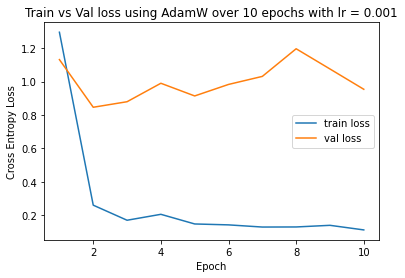

In [ ]:
x = np.arange(1, 10+1)
fig, ax = plt.subplots(1, 1)
ax.plot(x, optimizer_train_loss_curves[0], label="train loss")
ax.plot(x, optimizer_val_loss_curves[0], label="val loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Cross Entropy Loss")
ax.set_title("Train vs Val loss using AdamW over 10 epochs with lr = 0.001")
ax.legend()

In [ ]:
lrs = [1e-3, 1e-4, 5e-5, 1e-5, 1e-6]
lr_train_loss_curves = []
lr_val_loss_curves = []
for lr in lrs:
    config = config_class.from_pretrained(model_name, num_labels=50, output_hidden_states=True)
    bert = model_class.from_pretrained(model_name, config=config)
    
    nnet = NeuralNet(bert)
    loss_function = nn.CrossEntropyLoss()
    nnet.double().to(device)

    optimizer = optim.AdamW(nnet.parameters(), lr)
    train_losses, val_losses = train(nnet, optimizer, None, loss_function, 10)
    lr_train_loss_curves.append(train_losses)
    lr_val_loss_curves.append(val_losses)

x = np.arange(1, 10+1)
fig, ax = plt.subplots(1, 1)

for i, curve in enumerate(lr_val_loss_curves):
    ax.plot(x, curve, label='lr=' + str(lrs[i]))
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Cross Entropy Loss")
    ax.set_title("Losses of different learning rates")
    ax.legend()

In [ ]:
batch_sizes = [2, 4, 8, 16, 32]
batch_train_loss_curves = []
batch_val_loss_curves = []
for batch_size in batch_sizes:
    train_dataset = TensorDataset(train_input_ids, train_masks, train_bow, train_labels)
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

    test_dataset = TensorDataset(test_input_ids, test_masks, test_bow, test_labels)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

    config = config_class.from_pretrained(model_name, num_labels=50, output_hidden_states=True)
    bert = model_class.from_pretrained(model_name, config=config)
    nnet = NeuralNet(bert)
    loss_function = nn.CrossEntropyLoss()
    nnet.double().to(device)

    optimizer = optim.AdamW(nnet.parameters(), lr=1e-4)
    train_losses, val_losses = train(nnet, optimizer, None, loss_function, 10)
    batch_train_loss_curves.append(train_losses)
    batch_val_loss_curves.append(val_losses)

x = np.arange(1, 10+1)
fig, ax = plt.subplots(1, 1)

for i, curve in enumerate(batch_val_loss_curves):
    ax.plot(x, curve, label='batch_size=' + str(batch_sizes[i]))
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Cross Entropy Loss")
    ax.set_title("Losses of different batch sizes")
    ax.legend()

In [ ]:
gammas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gamma_train_loss_curves = []
gamma_val_loss_curves = []
for gamma in gammas:
    config = config_class.from_pretrained(model_name, num_labels=50, output_hidden_states=True)
    bert = model_class.from_pretrained(model_name, config=config)

    nnet = NeuralNet(bert)
    loss_function = nn.CrossEntropyLoss()
    nnet.double().to(device)

    optimizer = optim.AdamW(nnet.parameters(), lr=1e-4)
    if gamma == 0:
        scheduler = None
    else:
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=gamma)
    train_losses, val_losses = train(nnet, optimizer, scheduler, loss_function, 10)
    gamma_train_loss_curves.append(train_losses)
    gamma_val_loss_curves.append(val_losses)

x = np.arange(1, 10+1)
fig, ax = plt.subplots(1, 1)

for i, curve in enumerate(gamma_val_loss_curves):
    ax.plot(x, curve, label='gamma=' + str(gammas[i]))
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Cross Entropy Loss")
    ax.set_title("Losses of different gammas used in StepLR learning rate scheduler")
    ax.legend()

In [ ]:
gammas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gamma_train_loss_curves = []
gamma_val_loss_curves = []
for gamma in gammas:
    config = config_class.from_pretrained(model_name, num_labels=50, output_hidden_states=True)
    bert = model_class.from_pretrained(model_name, config=config)
    
    nnet = NeuralNet(bert)
    loss_function = nn.CrossEntropyLoss()
    nnet.double().to(device)

    optimizer = optim.AdamW(nnet.parameters(), lr=1e-4)
    if gamma == 0:
        scheduler = None
    else:
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=gamma)
    train_losses, val_losses = train(nnet, optimizer, scheduler, loss_function, 10)
    gamma_train_loss_curves.append(train_losses)
    gamma_val_loss_curves.append(val_losses)

x = np.arange(1, 10+1)
fig, ax = plt.subplots(1, 1)

for i, curve in enumerate(gamma_val_loss_curves):
    ax.plot(x, curve, label='gamma=' + str(gammas[i]))
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Cross Entropy Loss")
    ax.set_title("Losses of different gammas used in StepLR learning rate scheduler")
    ax.legend()


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    563.    Elapsed: 0:00:03.
  Batch    80  of    563.    Elapsed: 0:00:06.
  Batch   120  of    563.    Elapsed: 0:00:09.
  Batch   160  of    563.    Elapsed: 0:00:11.
  Batch   200  of    563.    Elapsed: 0:00:14.
  Batch   240  of    563.    Elapsed: 0:00:17.
  Batch   280  of    563.    Elapsed: 0:00:20.
  Batch   320  of    563.    Elapsed: 0:00:23.
  Batch   360  of    563.    Elapsed: 0:00:26.
  Batch   400  of    563.    Elapsed: 0:00:28.
  Batch   440  of    563.    Elapsed: 0:00:31.
  Batch   480  of    563.    Elapsed: 0:00:34.
  Batch   520  of    563.    Elapsed: 0:00:37.
  Batch   560  of    563.    Elapsed: 0:00:40.
Epoch: [1/10], elapsed: 0:00:40, loss: 3.8336612069940563, acc: 0.0608348134991119

Running Validation...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in double_scalars


Test :- elapsed: 0:00:04, loss: 3.5485216961757033, acc: 0.1349206349206349
Precision: 0.11390495847461792, Recall: 0.13599999999999998, F1: 0.09161586164712972, MCC: 0.0945775442661118

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    563.    Elapsed: 0:00:03.
  Batch    80  of    563.    Elapsed: 0:00:06.
  Batch   120  of    563.    Elapsed: 0:00:08.
  Batch   160  of    563.    Elapsed: 0:00:11.
  Batch   200  of    563.    Elapsed: 0:00:14.
  Batch   240  of    563.    Elapsed: 0:00:17.
  Batch   280  of    563.    Elapsed: 0:00:20.
  Batch   320  of    563.    Elapsed: 0:00:23.
  Batch   360  of    563.    Elapsed: 0:00:25.
  Batch   400  of    563.    Elapsed: 0:00:28.
  Batch   440  of    563.    Elapsed: 0:00:31.
  Batch   480  of    563.    Elapsed: 0:00:34.
  Batch   520  of    563.    Elapsed: 0:00:37.
  Batch   560  of    563.    Elapsed: 0:00:40.
Epoch: [2/10], elapsed: 0:00:40, loss: 3.3980909634599814, acc: 0.16629662522202487

Running Validation...
Test 

ValueError: ignored

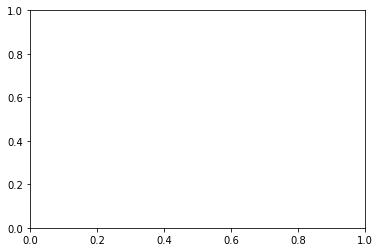

In [ ]:

nnet = NeuralNet(bert)
loss_function = nn.CrossEntropyLoss()
nnet.double().to(device)

optimizer = optim.AdamW(nnet.parameters(), lr=1e-4)
train_losses, val_losses = train(nnet, optimizer, None, loss_function, 10)

x = np.arange(1, 20+1)
fig, ax = plt.subplots(1, 1)


ax.plot(x, train_losses, label='train losses')
ax.plot(x, val_losses, label='val losses')
ax.set_xlabel("Epoch")
ax.set_ylabel("Cross Entropy Loss")
ax.set_title("Losses vs Epochs")
ax.legend()

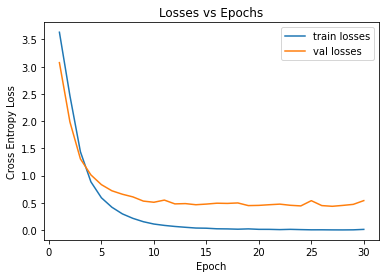

In [ ]:
x = np.arange(1, 30+1)
fig, ax = plt.subplots(1, 1)


ax.plot(x, train_losses, label='train losses')
ax.plot(x, val_losses, label='val losses')
ax.set_xlabel("Epoch")
ax.set_ylabel("Cross Entropy Loss")
ax.set_title("Losses vs Epochs")
ax.legend()

In [ ]:
text_ids = torch.tensor(np.arange(0, len(test_df)))
test_dataset = TensorDataset(test_input_ids, test_masks, test_bow, test_labels, text_ids)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

In [ ]:
# Error analysis

for batch in test_dataloader:

    input_ids, input_masks, bow, labels, text_ids = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        embeddings = nnet.bert(input_ids, attention_mask=input_masks)[1][0]
        embeddings = embeddings.mean(dim=1).double() 

        features_comb = torch.cat((embeddings, bow), dim=1)

        outputs = nnet(features_comb)
        vals, inds = torch.max(outputs, dim=1)
        text_ids = text_ids.detach().cpu().numpy()

        loss = loss_function(outputs, labels)
        eq = torch.eq(inds, labels)
        for i in range(eq.shape[0]):
            if eq[i]:
                print("CORRECT {}: {}".format(test_df.iloc[text_ids[i]].author, test_df.iloc[text_ids[i]].text))
            else:
                print("INCORRECT {} (Predicted: {}): {}".format(test_df.iloc[text_ids[i]].author, inds[i], test_df.iloc[text_ids[i]].text))
 
          

In [ ]:
model_filename = f'END_TO_END_{model_type}_{model_name}_max-length={MAX_LEN}.pth'
torch.save(nnet.state_dict(), ROOT + "/models/" + model_filename)